### idea 
user input his(personality test answers)and the system recommeds his matching Cats 


### metodology 
since our users don't have any prior preferences towards Cats(user cold start problem) we have to start with this:

1. Finding **nearset user**: the system takes user input (personality test answers) then finds the nearsest user (the most similar one) from our DataSet
    - for better pridections : we filterd out users with staisfacton level blow 0.8 

2. we get the nearest user - **Connceted Cat** (from the DataSet)

3. based on the **Connceted Cat** the system recommends the nearset cat from an external data set "Cat_dataset_online"


some notes: 

- there isn't any active learning,the system just recommends based on the Dataset (aka. the scale where every user get his recommended cat)  
- due to the DataSet setup, each user is exposed to one and only one Cat (Aka. each user rates one Cat). so we are forced to use "**user_based** collaborative filtering", in Addition satisfaction here is based on live -interaction between the Adopter and the cat for some time, so the satisfaction is a reliable scale 




###  for relasing this we need 

- **important** write a reveiw on the results and specify why we used coverage as main evaluation 
- **important** explain what is version2 in more details and do coverage test 
- **good to try** for example jaccard distance as an alternative methoud 




##### done 
-  encapsulationg the version 2 into a proper function 
-  Cats random names feature 
- **impotant** try another algorism  (cosine simlarity done .... may evalute it according to coverage (done)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

# pip install names
import names


pd.set_option('display.max_columns', 1000)

## Dataset preparation 

In [2]:
df = pd.read_excel('https://github.com/TechLabs-Berlin/wt21-pet-match/blob/main/ds_documentation/data_set/data_cleaned/all_cleaned_num.xlsx?raw=true')
#df.describe()

In [3]:
df = df.set_index('id').drop(columns = 'breed')
## we only had ~640 who spcifiy the breed name out of 3331,so we decided to drop this feature at this version of the recommender 

In [4]:
df.head()

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient,satisf_level
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,1,2,2,1,3,4,4,3,2,3,1,3,2,4,3,4,5,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4,1.00
1,2,2,2,1,1,3,4,4,1,4,3,3,2,3,4,3,5,2,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5,1.00
2,5,1,1,1,1,4,5,3,4,2,2,3,4,3,3,2,3,3,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0,0.85
3,4,2,2,1,1,4,3,4,3,5,4,2,2,2,5,4,4,4,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3,1.00
4,3,2,2,1,1,5,4,3,5,2,3,1,4,3,4,3,4,3,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4,1.00


### Random Cat-Names feature

- to for the easy identifaction of Cats 

In [5]:
## based on the index no. it checks the Cat's gender then it assign a name for it  
def Random_names(i):
    
    while i < len(df):
        if df["cat_gender"][df.index[i]] == 1:
            return str(names.get_first_name(gender='male'))
        else:
            return str(names.get_first_name(gender='female'))
        

In [6]:
temp_names = []
for n in df.index:
    random_name=Random_names(n)
    temp_names.append(random_name)
    
#print(temp_names)
df["cat_name"] = temp_names 

In [7]:
df

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient,satisf_level,cat_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,1,2,2,1,3,4,4,3,2,3,1,3,2,4,3,4,5,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4,1.00,Sean
1,2,2,2,1,1,3,4,4,1,4,3,3,2,3,4,3,5,2,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5,1.00,Noemi
2,5,1,1,1,1,4,5,3,4,2,2,3,4,3,3,2,3,3,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0,0.85,Albert
3,4,2,2,1,1,4,3,4,3,5,4,2,2,2,5,4,4,4,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3,1.00,Norma
4,3,2,2,1,1,5,4,3,5,2,3,1,4,3,4,3,4,3,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4,1.00,Mary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,12,2,1,1,1,3,5,5,3,4,4,1,4,2,5,4,5,2,2,5,2,1,2,1,4,4,4,2,3,4,3,1,5,5,4,1,4,1.00,Kimberly
3327,7,1,2,1,1,3,5,4,3,4,3,1,4,1,5,5,4,2,2,4,0,2,2,1,4,3,4,4,5,5,5,2,5,5,4,4,5,1.00,Shawn
3328,4,1,1,1,1,3,5,5,5,5,1,1,5,2,5,5,5,1,2,1,3,1,5,5,3,3,2,4,5,5,5,4,5,5,3,5,4,1.00,Douglas


### filtering out the unstisfied users 

- the recommender needs the users and Adopters to be high satisfied, we choose to remove subjects with satisfaction less than 0.8 

<AxesSubplot:title={'center':'Satisfaction Distribution'}>

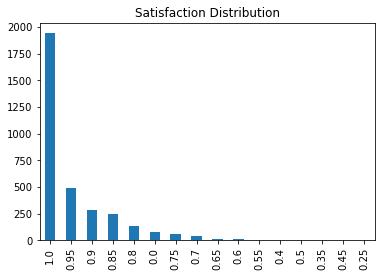

In [8]:
df['satisf_level'].value_counts().plot(kind='bar',title='Satisfaction Distribution' ,label= '.')

- nearly 58% are fully staisfied (satisfaction = 1), while (~10%) are blew 0.8 satisfaction.

In [9]:
#df['satisf_level'].value_counts(normalize = True)

### used Dataset (offline_Dataset)

In [10]:
df_happy = df.loc[df["satisf_level"] > 0.8].drop(columns=["satisf_level"]).reset_index(drop=True)

## Recommender idea

to enable the matching with new Cats that the Adopter have never seen the Rocmmender we do the following steps:
to do this we will need two Datasets:
 
1. the **original Dataset (offline Dataset)**: it contains the Adopter and cat Data together, this is the Recommender refrence
2. make a new **catDataset (cats online dataset)** to simulte the case of the website's cat database, for testing puposes it was made by producing a subset of the original Data (50% of the data)

steps 
1. the user input his data (using the questionare) .. this is applied using the API 
2. the rcommender apply the **1st cycle** of matching to get the **best_matching user**, based on a utility matrix table made from Adopter's features only 
3. the recommender extract the best user's **connected cat** data from the offline Dataset (1st choice)
4. the recommnder apply the **2nd cycle** of matching to get the **best_matching Cats** from the **cats online dataset**, based on a utility matrix table made from the cat features only 
5. the reommender sorts the results and gets the best 10 

### Cat online Dataset
- the online Dataset (Cat online) is a random sample of the original Dataset, we kept original IDs before doing ".sample" and coded it with "C" symbol (for debugging purposes), this will help to check the path of the data later. 

In [11]:
df_cats = df_happy.loc[:, "cat_age":"fearful"] 
df_cats_online=df_cats.sample(frac=0.6, replace=True, random_state=100).drop_duplicates()

# to cheak for duplictes using .sample
#print(len(df_cats["ID-cat"].unique()))
#print(len(df_cats_online["ID-cat"].unique()))
#len(df_cats_online["ID-cat"])

In [12]:
df_cats_online["ID-original"] =  "C-" + df_cats_online.index.astype(str)
df_cats_online = df_cats_online.set_index("ID-original")
df_cats_online

,cat_age,cat_gender,needs_outdoor,medical_conditions,behavioural_problems,cat_weight,likes_to_explore,playful,vocal,picked_up,timid,aggressive,adapts_quickly,prefers_alone,likes_stroke,tolerant_handled,friendly,fearful
ID-original,,,,,,,,,,,,,,,,,,
C-1544,1,1,1,2,1,3,5,5,3,5,1,1,5,1,5,5,5,1
C-2840,10,1,2,2,1,3,3,4,5,4,1,1,5,3,5,5,5,1
C-1859,4,1,2,1,1,3,5,5,1,4,4,1,3,2,5,5,4,4
C-79,5,1,2,1,1,3,5,5,5,4,3,1,3,1,3,3,5,1
C-1930,7,2,2,1,1,3,5,4,3,4,3,1,3,2,4,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C-1036,1,1,2,1,1,3,4,5,5,5,3,1,4,2,5,3,5,3
C-2046,5,1,2,1,1,3,4,3,3,4,1,1,4,3,3,4,4,1
C-102,1,2,2,1,1,2,4,3,5,4,4,1,2,4,5,5,4,3


### Finding nearest user (utility matrix table)

In [13]:
# setting up a subset for the users_only features 
df_adopters = df_happy.loc[:, "adopter_gender":"efficient"]
df_adopters

,adopter_gender,adopter_age,other_cats,outdoor_access,worries,easily_nervous,remains_calm,talkative,outgoing,reserved,new_ideas,values_artistic,active_imagination,rude,forgiving,considerate,thorough job,lazy,efficient
0,2,2,2,2,5,4,4,4,4,4,2,5,3,1,4,5,4,4,4
1,2,2,0,2,5,5,5,4,3,5,4,3,4,3,5,5,5,1,5
2,2,1,0,1,5,0,0,4,0,2,3,0,4,0,4,0,5,0,0
3,2,1,1,2,5,5,2,4,3,4,4,5,5,4,5,4,3,4,3
4,2,2,3,2,4,4,4,2,3,4,3,3,3,3,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,2,5,2,1,2,1,4,4,4,2,3,4,3,1,5,5,4,1,4
2963,2,4,0,2,2,1,4,3,4,4,5,5,5,2,5,5,4,4,5
2964,2,1,3,1,5,5,3,3,2,4,5,5,5,4,5,5,3,5,4
2965,2,3,1,1,4,4,4,1,5,2,3,5,4,4,1,5,5,2,5


In [14]:
# create utility matrix table to study the user and book relation
df_pivot=df_adopters.transpose()
df_pivot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,

In [15]:
##to cheak no. of people who didnt fill at least half of the questionnare , only 75 persons so it is negegable 
df_pivot[df_pivot==0].apply(lambda x: x.count()>5).value_counts()

False    2892
True       75
dtype: int64

In [16]:
x=df_pivot.values.T  
#x.shape

####  engines used in Recommender 

##### Correlation Matrix 

In [17]:
corr_mat = np.corrcoef(x)
###another methoud using Dataframe 
#df_matrix= df_pivot.corr(method='pearson')
#df_matrix

##### cosine similarity 

In [18]:
## another engine consine simlatiy 
cos_sim_mat = cosine_similarity(x)

### 1st cycle : get nearest user's connceted cats 

this approch is not enough, as we recommend cats from our offline Data set, it is better to get the nearest cats from separte Dataset (apply the 2nd cycle ) 

- for testing purposes only, we applied 1 cycle correlation definition here

#### recommender (1 cycle)_using correlation matrix (for testing only) 

In [19]:
### to be deleted ####

def recommend_one_cycle(df_pivot, corr_mat):
    name=int (input("Enter the Adopter name you want to match: ")) ## reomve the int, case your input is string 
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            corr_Adopter = corr_mat[Adopter_index]
            tuples = list(zip(Adopter_names,corr_Adopter,Cat_names))
            tuples_df = pd.DataFrame(data =tuples, columns= ["ID_matching","correlation","cat_name"])
            print("the nearest 10 cats to ",Adopter_index ," are")
            print(tuples_df.sort_values(by = "correlation", ascending = False).iloc[1:11])
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat(df_pivot,corr_mat)    

#### recommender (1 cycle)_using cosine similarity (for testing only) 

In [20]:
def bestuser_one_cycle_cosineSim(cos_sim_mat):
    name=int (input("Enter the Adopter name you want to match: "))
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            cos_Adopter = cos_sim_mat[Adopter_index] 
            tuples2 = list(zip(Adopter_names,cos_Adopter,Cat_names))
            tuples_df2 = pd.DataFrame(data =tuples2, columns= ["ID_matching","correlation","cat_name"])
            print("the nearest 10 cats to ",Adopter_index ," are")
            print(tuples_df2.sort_values(by = "correlation", ascending = False).iloc[1:11])
        
    except:
        print("Enter the Adopter Name Again")

##### quick glance at the results

In [21]:
recommend_one_cycle(df_pivot, corr_mat)

Enter the Adopter name you want to match: 20
the nearest 10 cats to  20  are
      ID_matching  correlation  cat_name
513           513     0.970695   Shirley
1444         1444     0.958436     Grace
1646         1646     0.942318    Thomas
2762         2762     0.926701    Thomas
798           798     0.923953   Michael
438           438     0.920922      Lori
48             48     0.915050     Ellen
170           170     0.913472   Chantel
1002         1002     0.912423  Charlene
997           997     0.909107  Paulette


In [32]:
bestuser_one_cycle_cosineSim(cos_sim_mat)

Enter the Adopter name you want to match: 20
the nearest 10 cats to  20  are
      ID_matching  correlation cat_name
513           513     0.996101  Shirley
1444         1444     0.994265    Grace
1646         1646     0.992683   Thomas
2762         2762     0.990658   Thomas
438           438     0.990202     Lori
798           798     0.990156  Michael
48             48     0.989469    Ellen
2019         2019     0.988767     Lynn
418           418     0.988767   Norman
1673         1673     0.988710    Karen


- the recommender results are identical in the 1st four choices then it vary after that, and since we are only picking the best choice so the variation in this cycle may not be very important  

### 2nd cycle:  finding  the best matching Cat from an online dataset

- matching to get the **best_matching Cats** from the **cats online dataset**, based on a utility matrix table made from the cat features only   

In [23]:
df_cats_online
cat_Ids = df_cats_online.index

### input Adopter Data then Extract the best connected Cat  (For degugging )

In [24]:
##adopter things 
Adopter_names = df_pivot.columns
Adopter_list = list(Adopter_names)
Adopter_index = Adopter_list.index(20) ### Enter adopter ID here ### 
Cat_names = df_happy["cat_name"].tolist()

#applying the 1st cycle logic 
corr_Adopter = corr_mat[Adopter_index]


#best Adopter
best_adopter = list(zip(Adopter_names,corr_Adopter))
df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
print("the nearest adopter to ",Adopter_index ," is")
print(df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2])

# extracting best cat data from the offline Dataset
best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index

best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] ## extracting the conncected cat part 
#best_cat 


the nearest adopter to  20  is
     ID_Adopter  correlation_Adopter
513         513             0.970695


- from the original dataset: the neaerst Adopter to pick is "513"

####  Finding nearest connected cat ( cat -utility matrix table)

In [25]:
#adding our imaginary best cat to the online cat_dataset

df_cats_online_new =df_cats_online.append(best_cat , sort=False) ## in case index dont match 
df_pivot_cat=df_cats_online_new.transpose()
df_pivot_cat

##to cheak no. of samples which didnt fill at least half of the questionnare 
#df_pivot_cat[df_pivot==0].apply(lambda x: x.count()>5).value_counts()

ID-original,C-1544,C-2840,C-1859,C-79,C-1930,C-350,C-1972,C-1890,C-53,C-1602,C-1550,C-802,C-1009,C-2800,C-280,C-1679,C-1899,C-1340,C-2960,C-1531,C-1673,C-2134,C-2434,C-1691,C-1900,C-1924,C-2463,C-897,C-2805,C-1747,C-612,C-1028,C-2651,C-2883,C-135,C-2097,C-2365,C-782,C-763,C-2,C-889,C-617,C-2526,C-1427,C-2111,C-283,C-1393,C-806,C-2220,C-274,C-2240,C-437,C-1738,C-273,C-1608,C-1549,C-618,C-17,C-2116,C-488,C-2523,C-2003,C-2741,C-2894,C-13,C-1209,C-1484,C-2410,C-131,C-2630,C-1667,C-1236,C-394,C-1239,C-495,C-643,C-2921,C-1200,C-1835,C-2084,C-1797,C-839,C-2086,C-1118,C-2786,C-1194,C-2900,C-2143,C-1650,C-1100,C-2362,C-2150,C-938,C-2454,C-2810,C-1719,C-226,C-915,C-1845,C-2244,C-446,C-818,C-1476,C-2467,C-407,C-765,C-1813,C-409,C-262,C-1701,C-1894,C-1652,C-1210,C-1758,C-1843,C-2334,C-2626,C-243,C-439,C-2321,C-813,C-1509,C-2137,C-429,C-803,C-1040,C-1548,C-2669,C-1091,C-2268,C-788,C-2186,C-2824,C-473,C-2760,C-1438,C-1932,C-1682,C-1373,C-2935,C-1628,C-556,C-1081,C-2431,C-768,C-1609,C-1768,C-694,C-1858,C-1413,C-1459,C-346,C-2082,C-451,C-862,C-1998,C-2742,C-1101,C-212,C-2433,C-1038,C-1907,C-148,C-2216,C-2490,C-796,C-2002,C-2770,C-514,C-2623,C-2929,C-145,C-1274,C-477,C-736,C-2122,C-1822,C-668,C-1106,C-998,C-1425,C-653,C-2641,C-2933,C-2841,C-655,C-364,C-2170,C-2059,C-2661,C-1908,C-1814,C-2871,C-313,C-87,C-2739,C-1968,C-754,C-2045,C-506,C-1681,C-705,C-172,C-144,C-1206,C-2231,C-83,C-502,C-1578,C-1981,C-2808,C-2806,C-1829,C-1648,C-2161,C-465,C-2576,C-1094,C-994,C-1760,C-2953,C-2927,C-674,C-870,C-1163,C-1821,C-1885,C-2724,C-597,C-2652,C-2675,C-2372,C-119,C-829,C-2141,C-1522,C-804,C-2602,C-2829,C-304,C-2514,C-2592,C-2342,C-1320,C-2545,C-1422,C-38,C-628,C-214,C-1189,C-2176,C-872,C-2747,C-809,C-2189,C-2040,C-2135,C-2113,C-324,C-2230,C-2688,C-2391,C-1619,C-2826,C-2793,C-833,C-1154,C-2263,C-2087,C-758,C-1316,C-1315,C-1635,C-659,C-2180,C-1751,C-2634,C-909,C-2721,C-1368,C-2711,C-234,C-1595,C-2552,C-1032,C-1613,C-303,C-2807,C-1817,C-1392,C-1951,C-550,C-2512,C-215,C-468,C-357,C-2108,C-783,C-2451,C-660,C-1155,C-2405,C-11,C-1328,C-1926,C-2705,C-1385,C-2764,C-186,C-456,C-1787,C-2483,C-1659,C-158,C-1646,C-1234,C-1307,C-2374,C-2036,C-1837,C-1319,C-1458,C-942,C-2364,C-1488,C-2128,C-633,C-34,C-1233,C-470,C-1839,C-2943,C-2947,C-375,C-2777,C-1285,C-2754,C-1979,C-649,C-397,C-1347,C-2174,C-2895,C-2294,C-340,C-1871,C-1933,C-2379,C-1585,C-1765,C-2260,C-2854,C-1445,C-1624,C-1939,C-21,C-2048,C-1865,C-2797,C-292,C-1203,C-1057,C-2400,C-854,C-2809,C-410,C-507,C-2646,C-1502,C-2083,C-2835,C-2290,C-1716,C-1961,C-1838,C-690,C-1256,C-77,C-1868,C-2915,C-2027,C-1597,C-1852,C-2706,C-35,C-2103,C-2118,C-1433,C-2783,C-1643,C-698,C-2380,C-700,C-2065,C-1569,C-194,C-990,C-18,C-2534,C-748,C-997,C-1543,C-485,C-1008,C-1214,C-129,C-1791,C-333,C-926,C-2396,C-1680,C-2513,C-1376,C-20,C-1362,C-1510,C-1379,C-2903,C-2299,C-1496,C-2517,C-513,C-491,C-1018,C-478,C-2012,C-603,C-1430,C-1357,C-1712,C-879,C-187,C-1929,C-1477,C-1074,C-62,C-1991,C-817,C-14,C-2049,C-120,C-369,C-2546,C-2489,C-505,C-794,C-594,C-2448,C-563,C-1519,C-866,C-1152,C-1412,C-826,C-6,C-37,C-1108,C-720,C-421,C-1475,C-544,C-1000,C-2966,C-2024,C-284,C-1201,C-1501,C-2247,C-1901,C-300,C-1464,C-2053,C-1120,C-735,C-539,C-481,C-1374,C-604,C-1269,C-1916,C-849,C-2278,C-750,C-2055,C-2519,C-787,C-1878,C-1875,C-1675,C-293,C-1777,C-523,C-1310,C-453,C-961,C-1331,C-2163,C-1061,C-2293,C-2852,...,C-975,C-1109,C-2328,C-2930,C-2525,C-2215,C-2267,C-1826,C-1891,C-2493,C-2818,C-1500,C-2802,C-2624,C-645,C-81,C-2001,C-254,C-1420,C-2184,C-61,C-522,C-2214,C-163,C-1168,C-196,C-856,C-2465,C-1213,C-2938,C-680,C-2872,C-715,C-460,C-1957,C-769,C-2830,C-1363,C-1179,C-2327,C-50,C-558,C-2179,C-1938,C-1580,C-1615,C-404,C-2655,C-695,C-1874,C-1349,C-1251,C-1948,C-206,C-1700,C-1497,C-1721,C-387,C-1975,C-1796,C-869,C-1575,C-1281,C-1763,C-2344,C-156,C-392,C-757,C-32,C-1075,C-2499,C-2622,C-1192,C-2007,C-125,C-218,C-2575,C-1408,C-1343,C-2193,C-2208,C-2502,C-2524,C-1911,C-2605,C-2168,C-2492,C-2550,C-1170,C-979,C-964,C-2924,C-1707,C-457,C-72,C-820,C-877,C-1096,C-1138,C-1366,C-2515

In [26]:
### engine used in second cycle 

In [27]:
#x_cat=df_pivot_cat.values.T 

#correlation matrix 
df_matrix= df_pivot_cat.corr(method='pearson')
cat_match =df_matrix[best_cat_index[0]].values

##cosine simlarity 

#df_pivot_cat.set_index(best_cat_index[0])
#v = cosine_similarity(df_cats_online_new.values)
#df_cosine = pd.DataFrame(v, columns=df_cats_online_new.index.values, index=df_cats_online_new.index).reset_index()
#cat_match_cosine =df_cosine[best_cat_index[0]].values

In [28]:
#presenting results

matching_cat = list(zip(cat_match,Cat_names,cat_Ids))

matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
print("the nearest 10 cats to ",Adopter_index ," are")
matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[0:11]

the nearest 10 cats to  20  are


,correlation_cat,cat_name,ID_original
421,1.000000,Rodolfo,C-513
9,0.963722,Agnes,C-1602
241,0.942319,Crystal,C-2592
1191,0.926546,Sandra,C-1478
513,0.922293,Shirley,C-2074
931,0.913246,Edward,C-2354
296,0.911809,Paul,C-2108
93,0.908475,Burton,C-2454
1229,0.904463,James,C-2088
598,0.903754,Roger,C-966


- The Recommender predicts the "C-513" which belongs to Adopter "513", so the recommender is working as expected !! 

## Recommender with 2 cycles 

input user id then you get a Dataframe of best Cats based on the online Database

In [56]:
                                         ### correlation based recommender ### 
## input : Adopter ID      ## output : ist of reommended Cats IDs

def recommend_cat_corr(name):
    name=int (name) ## reomve the int, case your input is string 
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
    cat_Ids = df_cats_online.index
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            corr_Adopter = corr_mat[Adopter_index] ## finding the best user (maybe Knn, cosine simlarity can be good)
            #best Adopter
            best_adopter = list(zip(Adopter_names,corr_Adopter))
            df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
            
            #print("the nearest adopter to ",Adopter_index ," is")
            #print(df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2])

            # extracting nearset adopters cat data from the offline Dataset
            best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index
            best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] 
            #adding data to the online cat Dataset
            df_cats_online_new =df_cats_online.append(best_cat , sort=False) 

            ## making the new matrix (takes long time)
            df_pivot_cat=df_cats_online_new.transpose()
            df_matrix= df_pivot_cat.corr(method='pearson')
            cat_match =df_matrix[best_cat_index[0]].values

            #presenting results

            matching_cat = list(zip(cat_match,Cat_names,cat_Ids))
            matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
            #print("the nearest 10 cats to ",Adopter_index ," are")
            df_eval = matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[1:11]
            return df_eval
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat(df_pivot,corr_mat) 


In [61]:
## input : Adopter ID      ## output : ist of reommended Cats IDs
def recommend_cat_cosine(name):
    name=int (name)
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
    cat_Ids = df_cats_online.index
 
    try:
        if name in Adopter_list:
            
            Adopter_index = Adopter_list.index(name) 
            cos_Adopter = cos_sim_mat[Adopter_index]  ## finding the best user (maybe Knn, cosine simlarity can be good)
            #best Adopter
            best_adopter = list(zip(Adopter_names,cos_Adopter))
            df_adopterDset = pd.DataFrame(data =best_adopter, columns= ["ID_Adopter","correlation_Adopter"])
            #print("the nearest adopter to ",Adopter_index ," is")
            #df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2]

            # extracting nearset adopters cat data from the offline Dataset
            best_cat_index = df_adopterDset.sort_values(by = "correlation_Adopter", ascending = False).iloc[1:2].index
            best_cat =df_happy.loc[best_cat_index[0], "cat_age":"fearful"] ## extracting the conncected cat part
            

            #adding data to the online cat Dataset
            df_cats_online_new =df_cats_online.append(best_cat , sort=False) 

            ## making the new matrix 
            df_pivot_cat=df_cats_online_new.transpose()
        
            ## 2nd cycle logic 
            
            df_pivot_cat.set_index(best_cat_index[0])
            v = cosine_similarity(df_cats_online_new.values)

            df_cosine = pd.DataFrame(v, columns=df_cats_online_new.index.values, index=df_cats_online_new.index).reset_index()
            cat_match_cosine =df_cosine[best_cat_index[0]].values
            
            
       
            #presenting results

            matching_cat = list(zip(cat_match_cosine,Cat_names,cat_Ids))

            matching_cat_df = pd.DataFrame(data =matching_cat, columns= ["correlation_cat","cat_name","ID_original"])
            #print("the nearest 10 cats to ",Adopter_index ," are")
            df_eval = matching_cat_df.sort_values(by = "correlation_cat", ascending = False).iloc[1:11] ## we omit 1st choice so it doesnt pridect 
            return df_eval
        
    except:
        print("Enter the Adopter Name Again")
        recommend_cat_cosine(df_cats_online,cos_sim_mat)
        
    

In [62]:
recommend_cat_cosine(20)

,correlation_cat,cat_name,ID_original
9,0.986882,Agnes,C-1602
241,0.979259,Crystal,C-2592
296,0.967610,Paul,C-2108
513,0.965522,Shirley,C-2074
909,0.965079,David,C-1096
1074,0.963692,Daniel,C-2423
217,0.963492,Edward,C-1094
1191,0.963388,Sandra,C-1478
332,0.960790,Nancy,C-2947
686,0.960670,Andrew,C-1041


In [58]:
recommend_cat_corr(20)

,correlation_cat,cat_name,ID_original
9,0.963722,Agnes,C-1602
241,0.942319,Crystal,C-2592
1191,0.926546,Sandra,C-1478
513,0.922293,Shirley,C-2074
931,0.913246,Edward,C-2354
296,0.911809,Paul,C-2108
93,0.908475,Burton,C-2454
1229,0.904463,James,C-2088
598,0.903754,Roger,C-966
909,0.901367,David,C-1096


## Evaluation 
- for recommender evaluation, we used Covrage Test as our main test , (we need to spicify why ???)
 

In [ ]:
##diagrm code                             ### Can be deleted ###

#df_pres_count = pd.DataFrame(data =Adopter_total_Accuracy, columns= ["Adopter_Accuracy"]).value_counts(normalize=True)
#count_distribution=df_pres_count.plot(kind='bar',title='Accuracy count distribution')

## caluating Coverage
Steps 
- make a random sample of Adopter Dataset
- get 10 recommendation for each Adopter from this list (excluding the cat with the same ID as user)
- make a list of reommended Cats IDs 
- count unique catID
- coverage = num_unique_catIDs / number of recommendations (10*num_users)


 do this in three cycles and calcate the mean Coverage

In [76]:
# setting a test Datset of Adopter
df_adopters_Test_cover=df_adopters.sample(frac=0.1, replace=True, random_state=100).drop_duplicates()

### using correlation_matrix 

In [67]:
## this def makes a sample Dataframe from the Dataset then calcultes the coverage ##

## input : random state of the sample Dataframe , the % of the Dataframe sample 
## dependancey : recommend_Eval_corr, Adopters Dataset 

def coverage_corr(random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    recomnneded_catIDs =[]
    for n in df_adopters_Test.index :
        array=recommend_cat_corr(n)['ID_original'].unique()
        recomnneded_catIDs.extend(array)

    recomnneded_catIDs
    unique_cat_recommended = len(set(recomnneded_catIDs))
    no_of_recommendations = 10*Sample_num
    coverage= (unique_cat_recommended/no_of_recommendations)*100
    print ("coverage (correlation_Matrix) is" ,coverage )
    return coverage

In [ ]:
### debugging ##   ### can be deleted###

Sample_num = 5
recomnneded_catIDs =[]
for n in [0,1,2,3,4] :
        recommend_Eval_corr(n)
        recomnneded_catIDs.extend(recommend_Eval_corr(n))
print(recomnneded_catIDs)
print(len(recomnneded_catIDs))
unique_cat_recommended = len(set(recomnneded_catIDs))
print(unique_cat_recommended)
no_of_recommendations = 10*Sample_num
coverage= (unique_cat_recommended/no_of_recommendations)*100
print ("coverage(cosine similarity) is" ,coverage )

### using cosine simlarity 

In [73]:
## this def makes a sample Dataframe from the Dataset then calcultes the coverage ##

## input : random state of the sample Dataframe , the % of the Dataframe sample  

def coverage_cosine(random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    recomnneded_catIDs =[]
    for n in df_adopters_Test.index :
        array=recommend_cat_cosine(n)['ID_original'].unique()
        recomnneded_catIDs.extend(array)

    recomnneded_catIDs
    unique_cat_recommended = len(set(recomnneded_catIDs))
    no_of_recommendations = 10*Sample_num
    coverage= (unique_cat_recommended/no_of_recommendations)*100
    print ("coverage (cosine similarity) is" ,coverage )
    return coverage

### comparing the results 

In [68]:
## testing 
coverage_corr(100,0.1)
coverage_corr(15,0.1)
coverage_corr(1045,0.1)

coverage (correlation_Matrix) is 35.19298245614035
coverage (correlation_Matrix) is 35.563380281690144
coverage (correlation_Matrix) is 35.090909090909086


35.090909090909086

##### using correlation matrix the mean coverage is roughly 35.28% on a sample of 10% of our Dataset 

In [75]:
coverage_cosine(100,0.1)
coverage_cosine(15,0.1)
coverage_cosine(1045,0.1)

coverage (cosine similarity) is 34.63157894736842
coverage (cosine similarity) is 35.140845070422536
coverage (cosine similarity) is 34.909090909090914


34.909090909090914

##### using cosine similrity the mean coverage is roughly 34.89 % on a sample of 10% of our Dataset 

In [79]:
### Testing coverage results at different samples of the Dataset 
### WArning : This testing takes ~ 40 mnis so beware of that ### 

cover_testing_sample= np.array([0.1,0.3,0.5,0.7,0.9])
cover_corr_mat=[]
cover_cos_sim=[]
for n in [0.1,0.3,0.5,0.7,0.9]:
    cov= coverage_corr(100,n)
    cover_corr_mat.append(cov)
    cos =coverage_cosine(100,n)
    cover_cos_sim.append(cos)
    

covrage_comparing= list(zip(cover_testing_sample,cover_corr_mat,cover_cos_sim))
covrage_comparing_df = pd.DataFrame(data =covrage_comparing, columns= ["DataSet_sample","corr_mat","cos_sim"])
covrage_comparing_df

coverage (correlation_Matrix) is 35.19298245614035
coverage (cosine similarity) is 34.63157894736842
coverage (correlation_Matrix) is 16.03174603174603
coverage (cosine similarity) is 15.74074074074074
coverage (correlation_Matrix) is 10.986784140969164
coverage (cosine similarity) is 10.881057268722467
coverage (correlation_Matrix) is 8.681693989071038
coverage (cosine similarity) is 8.51775956284153
coverage (correlation_Matrix) is 7.378472222222222
coverage (cosine similarity) is 7.262731481481481


,DataSet_sample,corr_mat,cos_sim
0,0.1,35.192982,34.631579
1,0.3,16.031746,15.740741
2,0.5,10.986784,10.881057
3,0.7,8.681694,8.517760
4,0.9,7.378472,7.262731


<AxesSubplot:xlabel='DataSet_sample'>

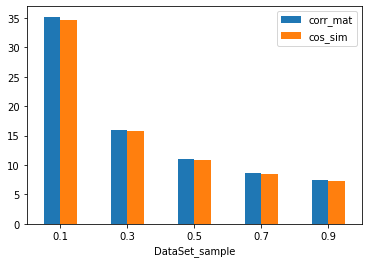

In [80]:
covrage_comparing_df.set_index("DataSet_sample").plot.bar(rot=0)

- the coverage decrease with bigger data set 
- there is a little advantage for the correlation_matrix methoud, however this diffrence decrease with the Dataset size
- the mean coverage for recommender is using "correlation matrix" is 7.3% on 90% (2670 Adopter) of our Dataset while using "Cosine_similarity" gives 7.2 %  

conclusion 

- at smalller DataSets (less than 500 Adopter) we can use the correlation methoud   

### Analyzing the correlation results  (this part can be deleted)
- note:here the recommender predict user input(correlation =1) as best choice, that validate that the results can be reliable
- we decided to look into +ve correlaltion numbers and anyalize it 

In [81]:
user_input = 17         ### for testing ### can be deleted ###

Adopter_names = df_pivot.columns
Cat_names = df_happy["cat_name"].tolist()
Adopter_list = list(Adopter_names)
Adopter_index = Adopter_list.index(user_input ) 
corr_Adopter = corr_mat[Adopter_index] 

## users are named with numbers for now

In [82]:
## to be deleted ##

corr_Adopter = corr_mat[Adopter_index] 
corr_Adopter.shape

tuples = list(zip(Adopter_names,corr_Adopter,Cat_names))
tuples_df = pd.DataFrame(data =tuples, columns= ["ID_matching","correlation","cat_name"])
print("the nearest 10 adopters  to ",Adopter_index ," are")
tuples_df.sort_values(by = "correlation", ascending = False).iloc[0:10]

the nearest 10 adopters  to  17  are


,ID_matching,correlation,cat_name
17,17,1.000000,Jerome
2740,2740,0.900869,Neil
1188,1188,0.890847,Ernest
292,292,0.876580,Vera
1224,1224,0.874159,Elva
847,847,0.855683,Franklin
860,860,0.850737,Sanford
656,656,0.848487,Alice
853,853,0.846810,Daniel
1941,1941,0.835498,Annie


       ID_matching   correlation
count  2325.000000  2.325000e+03
mean   1476.389677  2.330112e-01
std     853.679788  1.837504e-01
min       0.000000  1.175792e-17
25%     742.000000  9.215965e-02
50%    1457.000000  1.871658e-01
75%    2207.000000  3.242424e-01
max    2966.000000  1.000000e+00


<AxesSubplot:title={'center':'correlation Distribution'}>

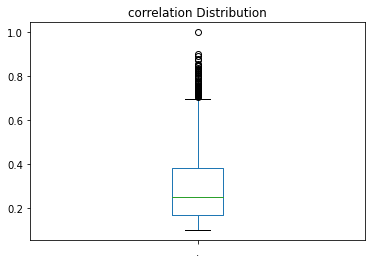

In [83]:
print(tuples_df.loc[tuples_df["correlation"]> 0].describe())

#analyzing the correlation numbers bigger than 1

tuples_df.loc[tuples_df["correlation"]> 0.1]["correlation"].plot(kind='box',title='correlation Distribution' ,label= '.')

In [ ]:
## with closer look into numbers around the 75% percentile   
tuples_df.loc[tuples_df["correlation"]> 0.75]["correlation"].plot(kind='box',title='correlation Distribution' ,label= '.')

- from here we can say that the outliers *above 0.85 correlation* are the ones who Can perform solid good prediction 

### Calculating Accuracy (for correlation _matrix only )

- to evalute the preformance we thought of clastering the pridections (aka. changing the result into a binary system)as follows:
    - relevant recommendation = correlation above 0.85
    - not relevant recommendation = else 
    
what column needed:
- reommendation clastering  .. to change it into Binary Classifier problem 
 Note : due to Dataset limition, as every Adopter rated one and only one cat, we couldnt varify both the False postive and , False negative  (aka. i cant measure the Precision and recall

In [84]:
df_eval=tuples_df.sort_values(by = "correlation", ascending = False).iloc[1:11]
df_eval['Relevant_recommendation'] =df_eval.groupby(['ID_matching'])["correlation"].apply(lambda x: (x > 0.85).sum())#.replace({1: "good", 0: "bad"})
df_eval

,ID_matching,correlation,cat_name,Relevant_recommendation
2740,2740,0.900869,Neil,1
1188,1188,0.890847,Ernest,1
292,292,0.876580,Vera,1
1224,1224,0.874159,Elva,1
847,847,0.855683,Franklin,1
860,860,0.850737,Sanford,1
656,656,0.848487,Alice,0
853,853,0.846810,Daniel,0
1941,1941,0.835498,Annie,0
1725,1725,0.831266,Eric,0


In [85]:
Accuracy  = df_eval['Relevant_recommendation'].sum()/len(df_eval)*100
print ("Accuracy value for user",user_input,"is" ,Accuracy  )
#possible_relevant_items = df_eval['Relevant_recommendation'].value_counts()[0]
#df_eval['Relevant_recommendation'].sum()/len(df_eval)

Accuracy value for user 17 is 60.0


In [86]:
## input : user ID , ## the def takes user ID and gives 

def recommender_single_user_Accuracy  (name):
    name=int (name) ## reomve the int, case your input is string 
    Adopter_names = df_pivot.columns
    Adopter_list = list(Adopter_names)
    Cat_names = df_happy["cat_name"].tolist()
 
    try:
        if name in Adopter_list:
            Adopter_index = Adopter_list.index(name) 
            corr_Adopter = corr_mat[Adopter_index]
            tuples = list(zip(Adopter_names,corr_Adopter,Cat_names))
            tuples_df = pd.DataFrame(data =tuples, columns= ["ID_matching","correlation","cat_name"])
            df_eval=tuples_df.sort_values(by = "correlation", ascending = False).iloc[1:11]
            df_eval['Relevant_recommendation'] =df_eval.groupby(['ID_matching'])["correlation"].apply(lambda x: (x > 0.85).sum())
            Accuracy = df_eval['Relevant_recommendation'].sum()/len(df_eval)*100
            #print ("Accuracy  values for user",name,"is" ,Accuracy ) ## for loop cheak
            return Accuracy 
        

    except:
        print("Error in id input")
        recommend_cat_eval(name) 


In [ ]:
recommender_single_user_Accuracy (17)

In [87]:
## testing in samll loob ##        ### Can be Deleted ###

Adopter_total_Accuracy =[]
for n in [0,1,2,3,4,5]:
    recommender_single_user_Accuracy (n)
    Adopter_total_Accuracy .append(recommender_single_user_Accuracy (n))

print(Adopter_total_Accuracy)
average_Accuracy = sum(Adopter_total_Accuracy )/len (Adopter_total_Accuracy ) 
average_Accuracy 

[80.0, 100.0, 100.0, 100.0, 10.0, 0.0]


65.0

In [88]:
## this def makes a sample Dataframe from the Dataset then calcultes the presision  ##

## input : random state of the sample Dataframe , the % of the Dataframe sample  

def Accuracy  (random_state,frac):
    df_adopters_Test=df_adopters.sample(frac=frac, replace=True, random_state=random_state).drop_duplicates()
    Sample_num = len(df_adopters_Test.index)
    Adopter_total_Accuracy =[]
    for n in df_adopters_Test.index :
        recommender_single_user_Accuracy(n)
        Adopter_total_Accuracy.append(recommender_single_user_Accuracy (n))
    Adopter_total_Accuracy
    df_pres_count = pd.DataFrame(data =Adopter_total_Accuracy, columns= ["Adopter_Accuracy"]).value_counts(normalize=True)
    count_distribution=df_pres_count.plot(kind='bar',title='Accuracy count distribution')
    average_Accuracy = sum(Adopter_total_Accuracy )/len (Adopter_total_Accuracy )
    print (count_distribution)

    print ("average_Accuracy is")
    return average_Accuracy 

AxesSubplot(0.125,0.125;0.775x0.755)
average_Accuracy is


66.6721044045677

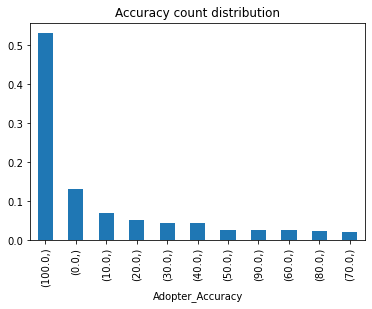

In [89]:
Accuracy  (100,1)

### 

### Knn idea 


In [ ]:
##input user 
name =df_adopters.loc[df_adopters.index[20]].tolist()
name_str =[name]
neigh_users = NearestNeighbors(n_neighbors=1, metric = 'correlation')
neigh_users.fit(df_adopters)
nearest_user = int(neigh_users.kneighbors(name_str, return_distance=False))
nearest_user

In [ ]:
neigh_cats = NearestNeighbors(n_neighbors=10, metric = 'correlation')
neigh_cats.fit(df_cats_online)
neigh_cats.kneighbors(pd.DataFrame(df_cats_online.iloc[nearest_user]).transpose())
result = pd.DataFrame(neigh_cats.kneighbors(pd.DataFrame(df_cats_online.iloc[nearest_user]).transpose(), return_distance=False)).transpose()
result.columns = ['catID']
result